# Homework

In this homework, we will use the Bank Marketing dataset.

In this dataset the target variable is y variable - has the client subscribed a term deposit or not.

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip

--2024-10-21 20:28:45--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K  1.02MB/s    in 1.0s    

2024-10-21 20:28:48 (1.02 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [7]:
import pandas as pd

In [8]:
df_homework = pd.read_csv('/workspaces/MLZoomCamp/04-evaluation/homework/bank-full.csv', sep = ';')

In [9]:
df_homework.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## Dataset preparation

In [38]:
df = df_homework[['age', 'job', 'marital', 'education', 'balance', 'housing',
                  'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
                  'previous', 'poutcome', 'y']]
df['y'] = (df['y'] == 'yes').astype(int)

/tmp/ipykernel_4916/2976030877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = (df['y'] == 'yes').astype(int)


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values
del df_train['y']
del df_val['y']
del df_test['y']

In [41]:
df_train.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [42]:
categorical = list(df_train.columns[df_train.dtypes == 'object'])
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [43]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [44]:
from sklearn.feature_extraction import DictVectorizer

In [45]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = (y_pred == y_val).mean()
accuracy.round(2)

0.9

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [46]:
from sklearn.metrics import auc, roc_auc_score
list_options = ['balance','day','duration','previous']
for c in list_options:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

         balance, 0.589
             day, 0.526
        duration, 0.815
        previous, 0.599


## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
auc = roc_auc_score(y_pred, y_val)
auc.round(3)

0.787

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score((y_pred>=0.5), y_val)
auc.round(3)

0.787

In [49]:
import numpy as np

In [64]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0, 1, 101)

scores_p = []
scores_r = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    scores_p.append(p)
    scores_r.append(r)

/tmp/ipykernel_4916/1803742985.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [65]:
import matplotlib.pyplot as plt

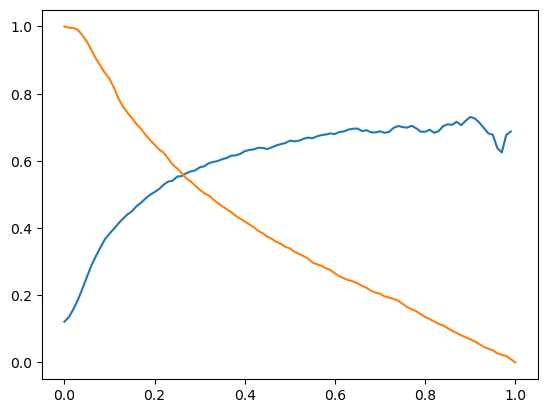

In [66]:
plt.plot(thresholds, scores_p, label = 'Precision')
plt.plot(thresholds, scores_r, label = 'Recall')
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

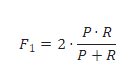

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [57]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0, 1, 101)

scores_f = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f = 2 * (p * r)/(p + r)
    scores_f.append(f)

/tmp/ipykernel_4916/3888557539.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


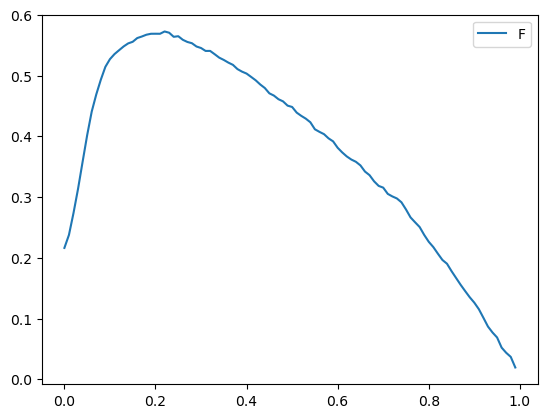

In [58]:
plt.plot(thresholds, scores_f, label = 'F')
plt.legend()
plt.show()

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [68]:
from sklearn.model_selection import KFold

In [70]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [71]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [84]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.std(scores), np.mean(scores)

(0.005496968608748504, 0.905951908446562)

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [79]:
from tqdm.auto import tqdm

In [82]:
for C in tqdm([0.000001, 0.001, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.005
C=10 0.906 +- 0.006
